<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_05_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Feature Engineering Order of Operations

In feature engineering, certain transformations are better applied before splitting the data into training and testing sets to avoid data leakage, while others can be applied after splitting. Here's how you can determine which transformations to apply before or after the split:

### Apply Before Train-Test Split:
1. **Interaction Features**: Creating new features by combining existing ones.
2. **Date Features**: Extracting features from date columns.
3. **Target Encoding**: Encoding categorical variables using the target variable (with caution).
4. **Binning**: Converting continuous variables into categorical variables.
5. **Ratio Features**: Creating ratio features (e.g., payment-to-bill ratios).
6. **Aggregations**: Creating features based on aggregations over certain periods (e.g., average bill amounts).

### Apply After Train-Test Split:
1. **Normalization/Standardization**: Scaling features to have a mean of zero and a standard deviation of one, or scaling to a specific range.
2. **Imputation**: Filling missing values with a specific strategy (mean, median, etc.).
3. **Encoding Categorical Variables**: One-hot encoding or label encoding.
4. **Polynomial Features**: Generating polynomial and interaction features.
5. **SMOTE, ADASYN, or Other Resampling Techniques**: Addressing class imbalance.

### Why Apply Certain Transformations After the Train-Test Split?
- **Prevent Data Leakage**: Ensuring that no information from the test set is used to influence the training process.
- **Consistent Scaling**: Calculating the parameters (mean, standard deviation) of scaling on the training set and then applying them to both the training and test sets.
- **Proper Imputation**: Filling missing values based on the distribution of the training set.

### Summary

- **Before Train-Test Split**: We applied feature engineering steps that create new features from existing ones, such as interaction features, target encoding, binning, ratio features, and aggregated features.
- **After Train-Test Split**: We performed transformations such as imputation, scaling, and one-hot encoding to ensure that these transformations are based only on the training set and applied consistently to both training and test sets.

This approach ensures that there is no data leakage and that the transformations are applied correctly. Let me know if you need any further adjustments or explanations!




### Define Features and Functions

In [27]:
import pandas as pd
import numpy as np
import torch
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, train_model, calculate_class_weights, convert_to_tensors, preprocess_data, define_preprocessor, SimpleNN, SklearnSimpleNN
import matplotlib.pyplot as plt

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Apply feature engineering to the entire dataset
def create_interaction_features(df):
    df['limit_bal_age'] = df['limit_bal'] * df['age']
    return df

def target_encode(df, target, categorical_columns):
    for col in categorical_columns:
        mean_target = df.groupby(col)[target].mean()
        df[col + '_target_enc'] = df[col].map(mean_target)
    return df

def bin_features(df, column, bins):
    df[column + '_binned'] = pd.cut(df[column], bins=bins)
    return df

def create_payment_to_bill_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_bill_ratio_{i}'] = df[f'pay_amt{i}'] / df[f'bill_amt{i}'].replace(0, np.nan)
    return df

def create_payment_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_limit_ratio_{i}'] = df[f'pay_amt{i}'] / df['limit_bal']
    return df

def create_bill_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'bill_to_limit_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_lagged_payment_differences(df):
    for i in range(1, 6):
        df[f'pay_amt_diff_{i}'] = df[f'pay_amt{i+1}'] - df[f'pay_amt{i}']
    return df

def create_debt_ratio_features(df):
    for i in range(1, 7):
        df[f'debt_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_average_payment_and_bill(df):
    df['avg_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
    df['avg_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
    return df

def create_payment_timeliness_features(df):
    for i in range(1, 7):
        df[f'pay_on_time_{i}'] = (df[f'pay_{i}'] <= 0).astype(int)
    return df

def create_total_payment_and_bill(df):
    df['total_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)
    df['total_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
    return df

def create_bill_difference_features(df):
    for i in range(1, 6):
        df[f'bill_diff_{i}'] = df[f'bill_amt{i+1}'] - df[f'bill_amt{i}']
    return df

# Evaluate the model and save the report before feature engineering
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    # print(f"Classification Report ({label}):")
    # print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

def compare_classification_reports(report_before, report_after):
    # Convert reports to DataFrame
    report_before_df = pd.DataFrame(report_before).transpose()
    report_after_df = pd.DataFrame(report_after).transpose()

    # Merge reports
    comparison_df = report_before_df.join(report_after_df, lsuffix='_before', rsuffix='_after')

    # Calculate percentage change
    comparison_df['precision_change'] = (comparison_df['precision_after'] - comparison_df['precision_before']) / comparison_df['precision_before'] * 100
    comparison_df['recall_change'] = (comparison_df['recall_after'] - comparison_df['recall_before']) / comparison_df['recall_before'] * 100
    comparison_df['f1-score_change'] = (comparison_df['f1-score_after'] - comparison_df['f1-score_before']) / comparison_df['f1-score_before'] * 100

    print("Comparison of Classification Report Metrics:")
    print(comparison_df[['precision_before', 'precision_after', 'precision_change',
                         'recall_before', 'recall_after', 'recall_change',
                         'f1-score_before', 'f1-score_after', 'f1-score_change']])

    return comparison_df

# Add features incrementally and test performance
def add_features_incrementally(data, features_to_add, target):
    results = []

    for feature in features_to_add:
        # Create a copy of the data to avoid modifying the original DataFrame
        data_copy = data.copy()

        # Apply the feature engineering function
        print(f"Adding feature: {feature['name']}")
        data_copy = feature['func'](data_copy)

        # Debug: Ensure the DataFrame shape remains consistent
        print(f"Data shape after adding {feature['name']}: {data_copy.shape}")

        # Split the data
        X_train, X_test, y_train, y_test = split_data(data_copy, target=target)

        # Preprocess the data
        preprocessor = define_preprocessor(X_train)
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

        # Convert data to tensors
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test)

        # Train the model
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=calculate_class_weights(y_train)[1])
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

        # Evaluate the model
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, f"With {feature['name']}")
        results.append({'feature': feature['name'], 'report': report})

    return results

def compare_classification_reports(report_before, report_after):
    # Convert reports to DataFrame
    report_before_df = pd.DataFrame(report_before).transpose()
    report_after_df = pd.DataFrame(report_after).transpose()

    # Merge reports
    comparison_df = report_before_df.join(report_after_df, lsuffix='_before', rsuffix='_after')

    # Calculate percentage change
    comparison_df['precision_change'] = (comparison_df['precision_after'] - comparison_df['precision_before']) / comparison_df['precision_before'] * 100
    comparison_df['recall_change'] = (comparison_df['recall_after'] - comparison_df['recall_before']) / comparison_df['recall_before'] * 100
    comparison_df['f1-score_change'] = (comparison_df['f1-score_after'] - comparison_df['f1-score_before']) / comparison_df['f1-score_before'] * 100

    print("Comparison of Classification Report Metrics:")
    print(comparison_df[['precision_before', 'precision_after', 'precision_change',
                         'recall_before', 'recall_after', 'recall_change',
                         'f1-score_before', 'f1-score_after', 'f1-score_change']])

    return comparison_df

# def compare_incremental_reports(report_baseline, incremental_results):
#     for result in incremental_results:
#         report_after = result['report']
#         feature_name = result['feature']

#         comparison_df = compare_classification_reports(report_baseline, report_after)

#         print(f"Comparison after adding feature: {feature_name}")
#         print(comparison_df)

def compare_incremental_reports(report_baseline, incremental_results):
    # Convert the baseline report to DataFrame
    report_baseline_df = pd.DataFrame(report_baseline).transpose()

    # Initialize a list to store comparison results
    all_comparisons = []

    # Iterate through the incremental results
    for result in incremental_results:
        report_after = result['report']
        feature_name = result['feature']

        # Convert the current report to DataFrame
        report_after_df = pd.DataFrame(report_after).transpose()

        # Merge the baseline and current reports
        comparison_df = report_baseline_df.join(report_after_df, lsuffix='_baseline', rsuffix=f'_{feature_name}')

        # Calculate percentage change
        comparison_df[f'precision_change_{feature_name}'] = (comparison_df[f'precision_{feature_name}'] - comparison_df['precision_baseline']) / comparison_df['precision_baseline'] * 100
        comparison_df[f'recall_change_{feature_name}'] = (comparison_df[f'recall_{feature_name}'] - comparison_df['recall_baseline']) / comparison_df['recall_baseline'] * 100
        comparison_df[f'f1-score_change_{feature_name}'] = (comparison_df[f'f1-score_{feature_name}'] - comparison_df['f1-score_baseline']) / comparison_df['f1-score_baseline'] * 100

        # Add the comparison result to the list
        all_comparisons.append(comparison_df)

    # Concatenate all comparison DataFrames
    all_comparisons_df = pd.concat(all_comparisons, axis=1)

    return all_comparisons_df


# visualize impact features on performance
def plot_metric_changes(all_comparisons_df, metric):
    # Extract percentage change columns for the specified metric
    change_cols = [col for col in all_comparisons_df.columns if col.startswith(f'{metric}_change')]

    # Extract feature names from the column headers
    feature_names = [col.split('_')[-1] for col in change_cols]

    # Plot the percentage changes
    changes = all_comparisons_df.loc[:, change_cols].iloc[0]  # assuming we want the changes for the first class (or overall if it's a macro/micro average)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, changes, color='skyblue')
    plt.axvline(x=0, color='gray', linestyle='--')  # Add vertical line at 0
    plt.xlabel('Percentage Change')
    plt.title(f'Percentage Change in {metric.capitalize()} After Adding Each Feature')
    plt.grid(axis='x')
    plt.show()

### Load and Preprocess Data

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, train_model, calculate_class_weights, convert_to_tensors, preprocess_data, define_preprocessor, SimpleNN, SklearnSimpleNN

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
data = rename_columns(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Define preprocessor and preprocess the data
preprocessor = define_preprocessor(X_train)
X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

# Convert data to tensors
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test)


### Train and Evaluate the Model (Baseline)

In [3]:
# Train the model without feature engineering (baseline)
nn_estimator_before = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=calculate_class_weights(y_train)[1])
nn_estimator_before = train_model(nn_estimator_before, X_train_tensor, y_train_tensor)

# Evaluate the baseline model and save the report
report_baseline = evaluate_model(nn_estimator_before, X_test_tensor, y_test_tensor, "Baseline Model")


Classification Report (Baseline Model):
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      4673
         1.0       0.52      0.54      0.53      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.70      0.70      6000
weighted avg       0.79      0.79      0.79      6000



## Incrementally Add Features and Evaluate the Model

In [14]:
# Define the features to add and their functions
features_to_add = [
    {'name': 'limit_bal_age', 'func': create_interaction_features},
    {'name': 'target_encoded', 'func': lambda df: target_encode(df, target, categorical_columns)},
    {'name': 'age_binned', 'func': lambda df: bin_features(df, 'age', 5)},
    {'name': 'pay_to_bill_ratios', 'func': create_payment_to_bill_ratios},
    {'name': 'pay_to_limit_ratios', 'func': create_payment_to_limit_ratios},
    {'name': 'bill_to_limit_ratios', 'func': create_bill_to_limit_ratios},
    {'name': 'lagged_payment_differences', 'func': create_lagged_payment_differences},
    {'name': 'debt_ratios', 'func': create_debt_ratio_features},
    {'name': 'average_payment_and_bill', 'func': create_average_payment_and_bill},
    {'name': 'payment_timeliness_features', 'func': create_payment_timeliness_features},
    {'name': 'total_payment_and_bill', 'func': create_total_payment_and_bill},
    {'name': 'bill_difference_features', 'func': create_bill_difference_features}
]

# Apply features incrementally and test performance
incremental_results = add_features_incrementally(data, features_to_add, target)

Adding feature: limit_bal_age
Data shape after adding limit_bal_age: (30000, 25)
Adding feature: target_encoded
Data shape after adding target_encoded: (30000, 28)
Adding feature: age_binned
Data shape after adding age_binned: (30000, 26)
Adding feature: pay_to_bill_ratios
Data shape after adding pay_to_bill_ratios: (30000, 31)
Adding feature: pay_to_limit_ratios
Data shape after adding pay_to_limit_ratios: (30000, 31)
Adding feature: bill_to_limit_ratios
Data shape after adding bill_to_limit_ratios: (30000, 31)
Adding feature: lagged_payment_differences
Data shape after adding lagged_payment_differences: (30000, 30)
Adding feature: debt_ratios
Data shape after adding debt_ratios: (30000, 31)
Adding feature: average_payment_and_bill
Data shape after adding average_payment_and_bill: (30000, 27)
Adding feature: payment_timeliness_features
Data shape after adding payment_timeliness_features: (30000, 31)
Adding feature: total_payment_and_bill
Data shape after adding total_payment_and_bill:

### Compare Report

In [24]:
# Compare the classification reports before and after each feature addition
all_comparisons_df = compare_incremental_reports(report_baseline, incremental_results)
all_comparisons_df

,precision_baseline,recall_baseline,f1-score_baseline,support_baseline,precision_limit_bal_age,recall_limit_bal_age,f1-score_limit_bal_age,support_limit_bal_age,precision_change_limit_bal_age,recall_change_limit_bal_age,...,recall_baseline,f1-score_baseline,support_baseline,precision_bill_difference_features,recall_bill_difference_features,f1-score_bill_difference_features,support_bill_difference_features,precision_change_bill_difference_features,recall_change_bill_difference_features,f1-score_change_bill_difference_features
0.0,0.867301,0.858763,0.863011,4673.000000,0.860948,0.878451,0.869611,4673.000000,-0.732461,2.292549,...,0.858763,0.863011,4673.000000,0.857585,0.890434,0.873701,4673.0000,-1.120272,3.688014,1.238691
1.0,0.519301,0.537302,0.528148,1327.000000,0.538961,0.500377,0.518953,1327.000000,3.785906,-6.872370,...,0.537302,0.528148,1327.000000,0.554007,0.479277,0.513939,1327.0000,6.683249,-10.799439,-2.690297
accuracy,0.787667,0.787667,0.787667,0.787667,0.794833,0.794833,0.794833,0.794833,0.909860,0.909860,...,0.787667,0.787667,0.787667,0.799500,0.799500,0.799500,0.7995,1.502328,1.502328,1.502328
macro avg,0.693301,0.698033,0.695579,6000.000000,0.699955,0.689414,0.694282,6000.000000,0.959728,-1.234744,...,0.698033,0.695579,6000.000000,0.705796,0.684855,0.693820,6000.0000,1.802251,-1.887757,-0.252934
weighted avg,0.790335,0.787667,0.788950,6000.000000,0.789735,0.794833,0.792057,6000.000000,-0.075849,0.909860,...,0.787667,0.788950,6000.000000,0.790443,0.799500,0.794134,6000.0000,0.013742,1.502328,0.656981


### Visualize Report

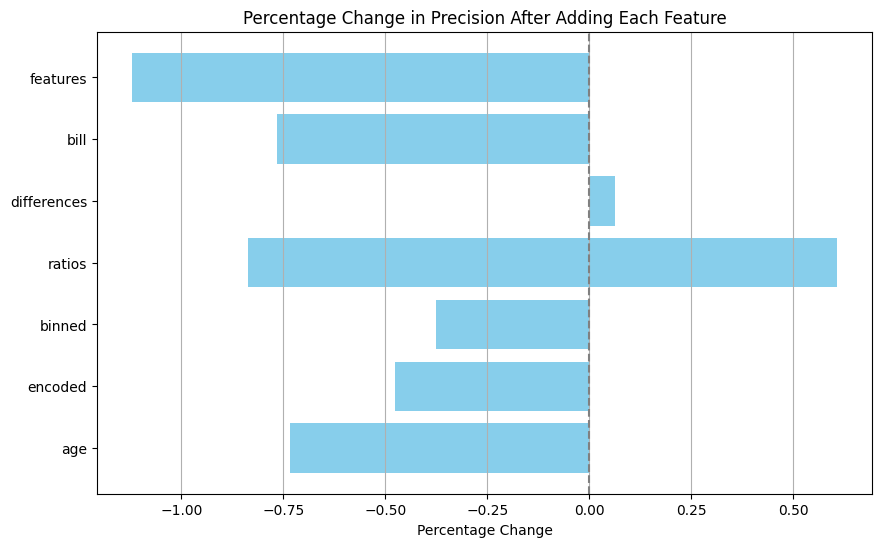

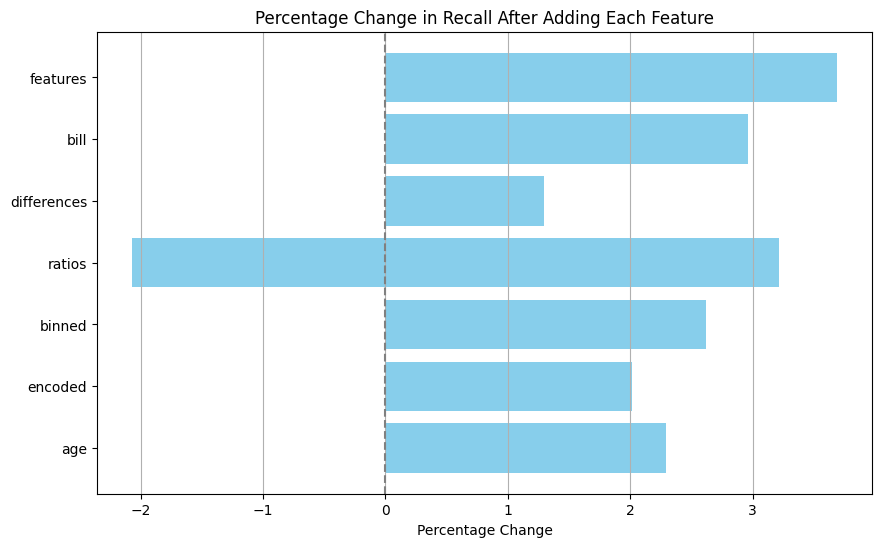

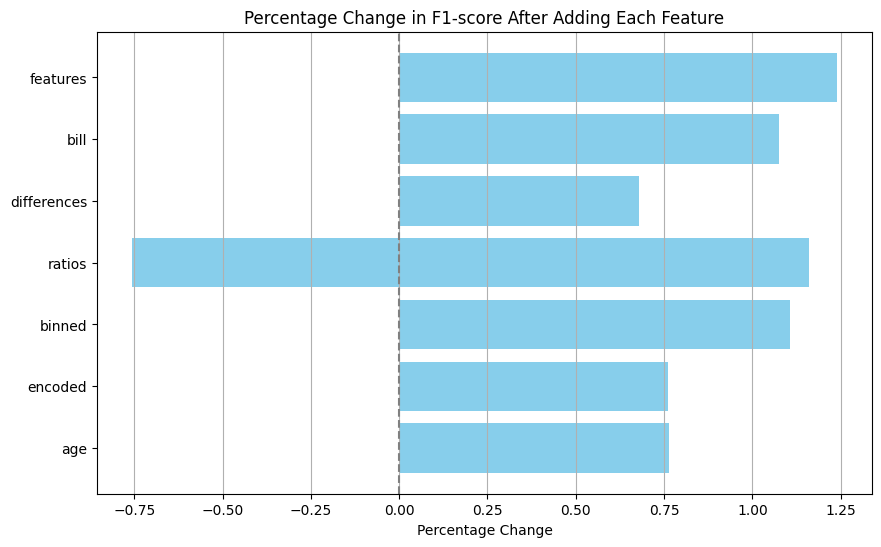

In [26]:
# Plot percentage changes for precision, recall, and f1-score
plot_metric_changes(all_comparisons_df, 'precision')
plot_metric_changes(all_comparisons_df, 'recall')
plot_metric_changes(all_comparisons_df, 'f1-score')

## Recursive Feature Elimination (RFE)

In [29]:
import pandas as pd
import numpy as np
import torch
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, train_model, calculate_class_weights, convert_to_tensors, preprocess_data, define_preprocessor, SimpleNN, SklearnSimpleNN

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
data = rename_columns(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Define preprocessor and preprocess the data
preprocessor = define_preprocessor(X_train)
X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

# Convert data to tensors
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test)


#### Define the Model and Apply RFE

In [30]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Define the model
model = LogisticRegression(max_iter=1000)

# Define RFE
rfe = RFE(model, n_features_to_select=10)  # Select the top 10 features

# Convert X_train_processed to DataFrame if not already
X_train_processed_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

# Fit RFE
rfe = rfe.fit(X_train_processed_df, y_train)

# Get the selected features
selected_features = X_train_processed_df.columns[rfe.support_]

print("Selected Features:", selected_features)


Selected Features: Index(['num__pay_1', 'num__bill_amt1', 'cat__education_0', 'cat__education_1',
       'cat__education_2', 'cat__education_3', 'cat__education_4',
       'cat__education_5', 'cat__education_6', 'cat__marriage_0'],
      dtype='object')


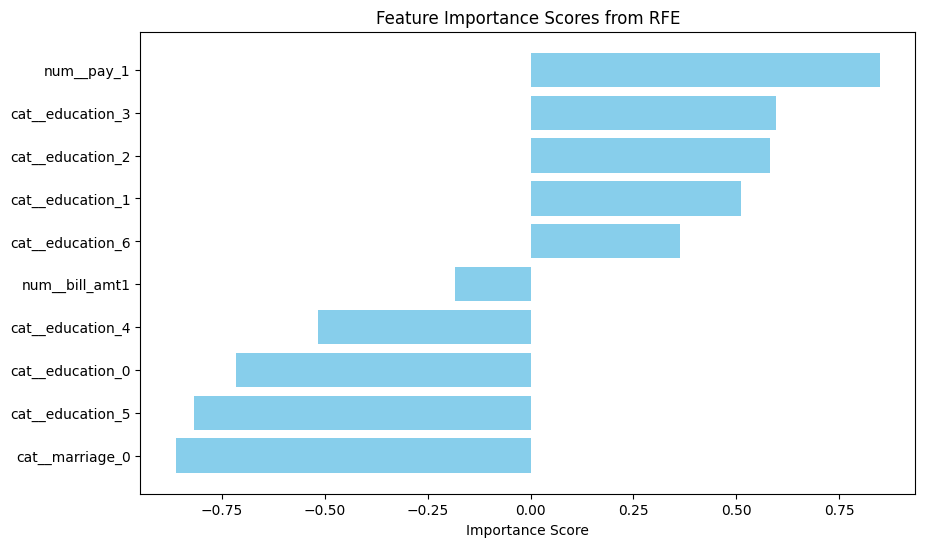

In [35]:
# Get the feature importance scores from the fitted RFE model
importance_scores = rfe.estimator_.coef_.flatten()

# Ensure the number of importance scores matches the number of selected features
if len(importance_scores) != len(X_train_processed_df.columns[rfe.support_]):
    raise ValueError("The number of importance scores does not match the number of selected features")

# Create a DataFrame to display feature names and their importance scores
importance_df = pd.DataFrame({
    'Feature': X_train_processed_df.columns[rfe.support_],
    'Importance': importance_scores
})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# print(importance_df)

# Plot the feature importance scores
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance Scores from RFE')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

In the context of a Logistic Regression model, feature importance values (coefficients) can be positive or negative, and this has a specific meaning:

1. **Positive Coefficients**: A positive coefficient indicates that an increase in the feature value will increase the log-odds of the positive class. In other words, higher values of this feature are associated with a higher probability of the positive outcome (e.g., defaulting on a payment).

2. **Negative Coefficients**: A negative coefficient indicates that an increase in the feature value will decrease the log-odds of the positive class. In other words, higher values of this feature are associated with a lower probability of the positive outcome.

### Interpreting the Coefficients

The magnitude of the coefficient indicates the strength of the feature's influence on the target variable:

- A larger absolute value means the feature has a stronger influence on the prediction.
- A smaller absolute value means the feature has a weaker influence on the prediction.

### Example

- If `num__pay_1` has a positive coefficient, it means that as the value of `pay_1` increases, the likelihood of defaulting on a payment increases.
- If `num__bill_amt1` has a negative coefficient, it means that as the value of `bill_amt1` increases, the likelihood of defaulting on a payment decreases.

### Updated Visualization Code to Highlight Positive and Negative Importances

### Summary

1. **Positive Coefficients**: Indicate an increase in the feature value is associated with an increase in the log-odds of the positive class.
2. **Negative Coefficients**: Indicate an increase in the feature value is associated with a decrease in the log-odds of the positive class.
3. **Magnitude of Coefficients**: Indicates the strength of the feature’s influence on the target variable.
4. **Visualization**: The updated bar plot with different colors for positive and negative values helps in visually distinguishing the direction of influence.

The selected features are chosen based on the Recursive Feature Elimination (RFE) process, which uses a model to evaluate the importance of each feature and recursively removes the least important ones. Here's a breakdown of how and why these features might have been selected:

### Explanation of RFE

1. **Initial Model Training**: RFE starts by training the specified model (in this case, Logistic Regression) on the entire set of features.
2. **Feature Ranking**: The model assigns a weight or importance score to each feature.
3. **Recursive Elimination**: The least important features (those with the smallest weights or importance scores) are removed one by one. This process is repeated until the desired number of features is reached.

### Selected Features

The selected features are:

- `num__pay_1`: The first payment status variable, which likely indicates whether a payment was missed or delayed.
- `num__bill_amt1`: The first bill amount, which could be indicative of the financial behavior or credit risk.
- `cat__education_*`: Various encoded categories of the education feature. Education level might correlate with default risk.
- `cat__marriage_0`: One of the encoded categories of the marriage feature, which could indicate marital status influences on credit behavior.

### Why These Features?

1. **Payment Status (`pay_1`)**: Payment history is a strong indicator of future default risk. If a customer has a history of missed or delayed payments, they are more likely to default.
2. **Bill Amount (`bill_amt1`)**: The amount of the bill can reflect the spending behavior and financial health of a customer. Larger or unpaid bills might indicate higher risk.
3. **Education (`education_0` to `education_6`)**: Education level can influence financial behavior and stability. Different education levels might have different default rates.
4. **Marital Status (`marriage_0`)**: Marital status can impact financial stability and spending habits. Different marital statuses might correlate with different risk levels.

### Analyzing Feature Importance

To better understand why these features were selected, we can look at the feature importance scores assigned by the Logistic Regression model used in RFE. Here's how to extract and analyze these scores:



In [31]:
# Define a function to preprocess data with selected features
def preprocess_selected_features(data, selected_features):
    return data[selected_features]

# Preprocess training and test data with selected features
X_train_selected = preprocess_selected_features(X_train, selected_features)
X_test_selected = preprocess_selected_features(X_test, selected_features)

# Convert data to tensors
X_train_tensor_selected, y_train_tensor, X_test_tensor_selected, y_test_tensor = convert_to_tensors(X_train_selected, y_train, X_test_selected, y_test)

# Train the model with selected features
nn_estimator_selected = SklearnSimpleNN(input_dim=X_train_tensor_selected.shape[1], pos_weight=calculate_class_weights(y_train)[1])
nn_estimator_selected = train_model(nn_estimator_selected, X_train_tensor_selected, y_train_tensor)

# Evaluate the model with selected features
report_selected = evaluate_model(nn_estimator_selected, X_test_tensor_selected, y_test_tensor, "Selected Features")

# Compare the report with baseline
comparison_selected = compare_classification_reports(report_baseline, report_selected)

# Plot the results for the selected features
plot_metric_changes(comparison_selected, 'precision')
plot_metric_changes(comparison_selected, 'recall')
plot_metric_changes(comparison_selected, 'f1-score')


KeyError: "None of [Index(['num__pay_1', 'num__bill_amt1', 'cat__education_0', 'cat__education_1',\n       'cat__education_2', 'cat__education_3', 'cat__education_4',\n       'cat__education_5', 'cat__education_6', 'cat__marriage_0'],\n      dtype='object')] are in the [columns]"

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Step 1: Define Functions (already done)

# Step 2: Load and Preprocess Data (already done)

# Step 3: Train and Evaluate the Model (Baseline) (already done)

# Step 4: Incrementally Add Features and Evaluate the Model (already done)

# Step 5: Compare the Reports for Each Feature Addition (already done)

# Step 6: Visualize Changes with Vertical Line at 0 (already done)

# Step 7: Implement Automated Feature Selection with RFE

# Define the model
model = LogisticRegression(max_iter=1000)

# Define RFE
rfe = RFE(model, n_features_to_select=10)  # Select the top 10 features

# Fit RFE
rfe = rfe.fit(X_train_processed, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:", selected_features)

# Define a function to preprocess data with selected features
def preprocess_selected_features(data, selected_features):
    return data[selected_features]

# Preprocess training and test data with selected features
X_train_selected = preprocess_selected_features(X_train, selected_features)
X_test_selected = preprocess_selected_features(X_test, selected_features)

# Convert data to tensors
X_train_tensor_selected, y_train_tensor, X_test_tensor_selected, y_test_tensor = convert_to_tensors(X_train_selected, y_train, X_test_selected, y_test)

# Train the model with selected features
nn_estimator_selected = SklearnSimpleNN(input_dim=X_train_tensor_selected.shape[1], pos_weight=calculate_class_weights(y_train)[1])
nn_estimator_selected = train_model(nn_estimator_selected, X_train_tensor_selected, y_train_tensor)

# Evaluate the model with selected features
report_selected = evaluate_model(nn_estimator_selected, X_test_tensor_selected, y_test_tensor, "Selected Features")

# Compare the report with baseline
comparison_selected = compare_classification_reports(report_baseline, report_selected)

# Plot the results for the selected features
plot_metric_changes(comparison_selected, 'precision')
plot_metric_changes(comparison_selected, 'recall')
plot_metric_changes(comparison_selected, 'f1-score')


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   limit_bal                   30000 non-null  int64   
 1   sex                         30000 non-null  category
 2   education                   30000 non-null  category
 3   marriage                    30000 non-null  category
 4   age                         30000 non-null  int64   
 5   pay_1                       30000 non-null  int64   
 6   pay_2                       30000 non-null  int64   
 7   pay_3                       30000 non-null  int64   
 8   pay_4                       30000 non-null  int64   
 9   pay_5                       30000 non-null  int64   
 10  pay_6                       30000 non-null  int64   
 11  bill_amt1                   30000 non-null  int64   
 12  bill_amt2                   30000 non-null  int64   
 13  bill_amt3       

The `target_encode` function is a feature engineering technique that replaces the categories of a categorical variable with the mean (or other statistic) of the target variable for each category. This method can be particularly useful when dealing with high-cardinality categorical features, where one-hot encoding would create too many dummy variables.

### Explanation of Target Encoding

Let's break down what the `target_encode` function does step by step:

1. **Group by Category and Compute Mean Target**:
   - The function groups the dataframe by each unique value of the categorical feature.
   - It then computes the mean of the target variable for each category.

2. **Map the Mean Target to the Original Data**:
   - The function maps the computed mean target values back to the original dataframe, replacing the categorical feature values with these mean target values.
   
### Benefits of Target Encoding

- **Dimensionality Reduction**: Unlike one-hot encoding, which can significantly increase the number of features, target encoding results in only one new feature for each categorical variable.
- **Capturing Impact on Target**: Target encoding captures the relationship between the categorical feature and the target variable, which can be beneficial for certain machine learning models.

### Potential Issues

- **Data Leakage**: If not applied correctly, target encoding can lead to data leakage, where information from the test set influences the training set. This is why it's important to perform target encoding based only on the training data and then apply the same encoding to the test data.
- **Overfitting**: Target encoding can sometimes lead to overfitting, especially if there are categories with few examples. Regularization techniques can be applied to mitigate this.





### Step 3: Split the Data into Training and Testing Sets




### Step 4: Define Preprocessing Pipelines and Apply to Training Data


### Step 5: Convert Data to Tensors and Train the Model

Determining which features improve the performance of a machine learning model is an iterative process that involves several steps. Here are the general steps you can follow to evaluate the impact of different features on your model's performance:

### 1. **Baseline Model**:
   - Start by building a baseline model with minimal preprocessing and feature engineering.
   - Evaluate the baseline model's performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score, AUC-ROC).

### 2. **Feature Addition/Removal**:
   - Incrementally add or remove features and observe changes in model performance.
   - This can be done manually or using automated methods like recursive feature elimination.

### 3. **Cross-Validation**:
   - Use cross-validation to ensure that the performance improvements are consistent and not due to random chance.
   - Cross-validation helps in providing a more robust estimate of the model's performance.

### 4. **Feature Importance**:
   - For models that provide feature importance (e.g., tree-based models like Random Forest, Gradient Boosting), examine the feature importance scores.
   - Identify the most influential features according to the model.

### 5. **Statistical Tests**:
   - Perform statistical tests to determine the significance of individual features.
   - Techniques like ANOVA, chi-square tests, and mutual information can help in understanding the relationship between features and the target variable.

### 6. **Model Performance Metrics**:
   - Monitor and compare key performance metrics before and after adding/removing features.
   - Common metrics include accuracy, precision, recall, F1-score, and AUC-ROC.

### 7. **Model Interpretation Tools**:
   - Use tools like SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to understand the impact of features on model predictions.

### Example: Feature Importance with Random Forest

Here’s an example of how you might use a Random Forest model to assess feature importance:

```python
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Fit a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_processed, y_train)

# Evaluate the model
y_pred = rf.predict(X_test_processed)
print(classification_report(y_test, y_pred))

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Cross-validation
cv_scores = cross_val_score(rf, X_train_processed, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {np.mean(cv_scores)}')
```

### Example: Using SHAP for Model Interpretation

SHAP values provide a way to understand the contribution of each feature to individual predictions:

```python
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_processed)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names)
```

### Summary Steps:
1. **Build a baseline model and evaluate its performance.**
2. **Incrementally add or remove features and observe changes in performance.**
3. **Use cross-validation to ensure consistent performance improvements.**
4. **Examine feature importance scores from models that support it.**
5. **Perform statistical tests to assess the significance of features.**
6. **Monitor key performance metrics to compare different feature sets.**
7. **Use model interpretation tools like SHAP or LIME to understand feature contributions.**

This iterative process helps in identifying the most impactful features and refining the model for better performance. If you have specific features or transformations you'd like to evaluate, I can help with implementing those as well.

### Updated model_pipeline.py script

In [8]:
script_content = """
import pandas as pd
import numpy as np
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the dataset from a URL
def load_data_from_url(url):
    df = pd.read_excel(url, header=1)
    return df

# Clean column names
def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Define the preprocessor
def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor

# Preprocess the data
def preprocess_data(preprocessor, X_train, X_test):
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

# Calculate class weights for imbalanced datasets
def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

# Convert data to PyTorch tensors
def convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test):
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

# Define the neural network model
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 32)
        self.fc2 = torch.nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Commented out the original SklearnSimpleNN class definition
# class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
#     def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
#         self.input_dim = input_dim
#         self.learning_rate = learning_rate
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.pos_weight = pos_weight
#         self.model = SimpleNN(self.input_dim)

#     def fit(self, X, y):
#         criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
#         optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
#         train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
#         train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

#         for epoch in range(self.epochs):
#             self.model.train()
#             for inputs, targets in train_loader:
#                 optimizer.zero_grad()
#                 outputs = self.model(inputs)
#                 loss = criterion(outputs, targets.view(-1, 1))
#                 loss.backward()
#                 optimizer.step()
#         return self

#     def predict(self, X):
#         self.model.eval()
#         with torch.no_grad():
#             if isinstance(X, np.ndarray):
#                 X = torch.tensor(X, dtype=torch.float32)
#             elif isinstance(X, pd.DataFrame):
#                 X = torch.tensor(X.values, dtype=torch.float32)
#             outputs = self.model(X)
#             probabilities = torch.sigmoid(outputs)
#             predictions = (probabilities > 0.5).float()
#         return predictions.numpy().squeeze()

# Updated SklearnSimpleNN class definition
class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32)
            elif isinstance(X, pd.DataFrame):
                X = torch.tensor(X.values, dtype=torch.float32)
            outputs = self.model(X)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
        return predictions.numpy().squeeze()

def train_model(nn_estimator, X_train_tensor, y_train_tensor):
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())
    return nn_estimator

def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    print(classification_report(y_test_tensor.numpy(), y_pred))

"""

# Append the functions to model_pipeline.py
with open("model_pipeline.py", "w") as file:
    file.write(script_content)

print("Functions written successfully to model_pipeline.py")

# reload script to make function available for use
import importlib
import model_pipeline
importlib.reload(model_pipeline)


Functions written successfully to model_pipeline.py


<module 'model_pipeline' from '/content/model_pipeline.py'>